In [2]:
# IMPORT PACKAGES
from package_bfry import *

/Users/brianfry/Documents/GitHub/Bologna/package_bfry/bfry.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()


In [ ]:
# HOUSEHOLD SIZE
# map the household size
base_map_2019.explore(column = 'avg_household_size', cmap = 'RdBu_r', tooltip = ('zona_fiu', 'population', 'households', 'avg_household_size'), 
                                          tiles = 'CartoDB positron', legend=True)

In [ ]:
# airbnb #
# base dataset : airbnb_agg

create_map(base_map_2019, airbnb_agg, 'household', 'airbnb', airbnb)

In [ ]:
# WIFI #
# base dataset : wifi_agg

# map the wifi per capita
create_map(base_map_2019, wifi_agg, 'population', 'hotspot', wifi, quotient = 1000)

In [ ]:
# PARTICIPATORY BUDGET #
# base dataset : budg_geo

    # process data for mapping
# aggregate the count of participative budget projects at the neighborhood level
# TO DO - resolve mixed geometry situation
#budg_agg = 
#gpd.overlay(base_map_2019, budg_geo, how='intersection', keep_geom_type=False) #.groupby('cod_zona').count()
#budg_agg
# rename and subset the data just to the count of the projects per neighborhood
#budg_agg = budg_agg.rename(columns={'Progetto':'project_count'})['project_count']
budg_geo.explore()
    # map the data
#create_map(base_map_2019, budg_agg, 'population', 'project', budg_geo, quotient = 1000)

In [ ]:
# STREET FURNITURE #
# base dataset : furniture
furniture_state_2019

In [ ]:
# explore traffic per capita at the zone level
transport_2019.explore(column = 'traffic_per_1000', cmap = 'RdBu_r')

In [ ]:
# explore bike parking per capita / household
transport_2019.explore(column = 'bike_parking_per_household', cmap = 'RdBu_r')

In [ ]:
# explore bus stops per capita
transport_2019.explore(column = 'tper_stops_per_1000', cmap = 'RdBu_r')

In [3]:
transport_2019.columns

Index(['geometry', 'population', '00-14', '15-29', '30-44', '45-64',
       '65 e oltre', 'households', 'n_taxpayers', 'avg_income',
       'taxpayers_per_cap', 'n_workers', 'n_students', 'workers_per_cap',
       'students_per_cap', 'pop_density_km2', 'avg_household_size',
       'n_incident', 'totale_fer', 'totale_mor', 'incident_per_1000',
       'injured_per_1000', 'injured_per_incident', 'mortality_per_1000',
       'avg_daily_traffic', 'traffic_per_1000', 'incident_per_traffic',
       'n_bike_parking', 'bike_parking_per_1000', 'bike_parking_per_household',
       'length_all_bike_m', 'length_safe_bike_m', 'bike_m_per_capita',
       'percent_safe_bike', 'tper_stops_per_1000'],
      dtype='object')

In [38]:
# MULTI VARIABLE ANALYSIS #
    # create a dataframe of variables to be analyzed together
    # can add or remove metrics for analysis as needed
df = transport_2019[['population', '00-14', '15-29', '30-44', '45-64',
       '65 e oltre', 'avg_income',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size', 'traffic_per_1000', 'injured_per_incident', 'incident_per_traffic', 'bike_parking_per_household', 'bike_m_per_capita',
       'percent_safe_bike', 'tper_stops_per_1000']]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


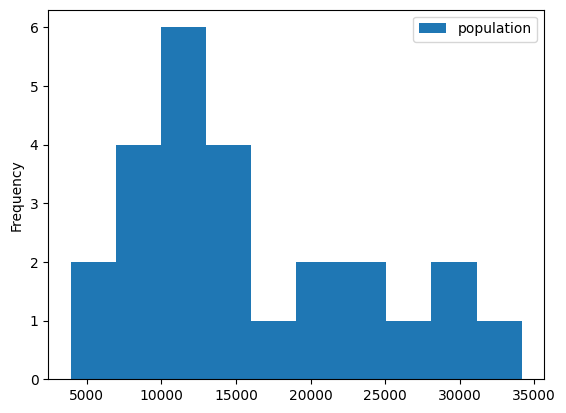

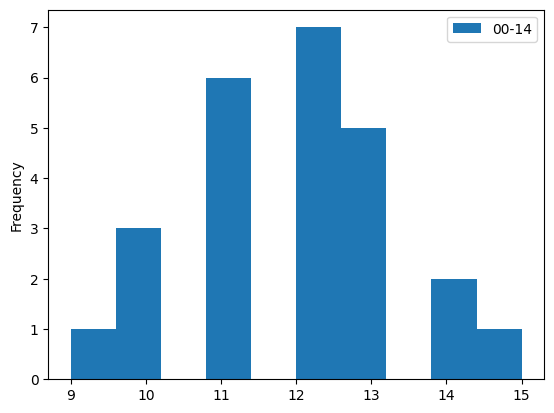

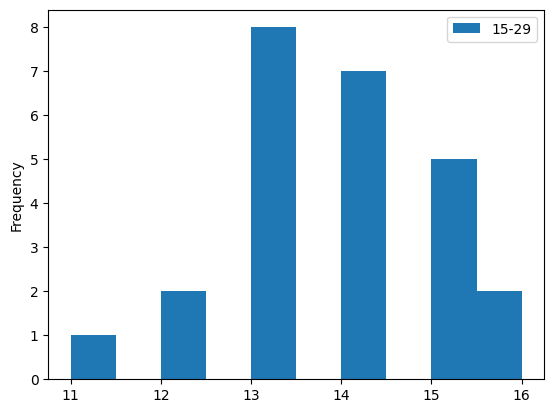

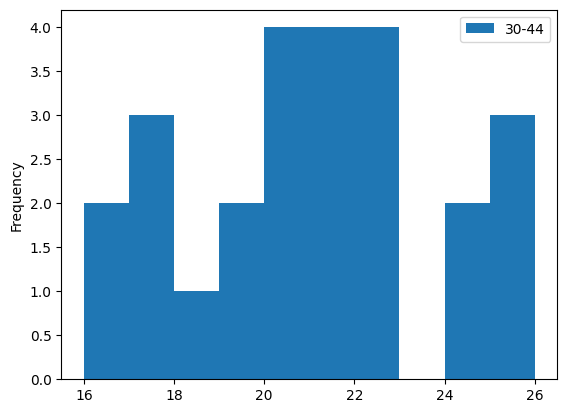

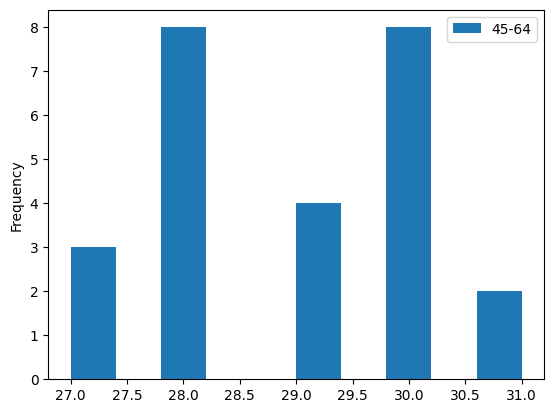

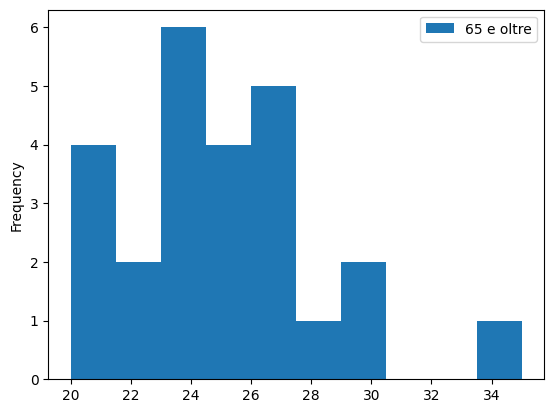

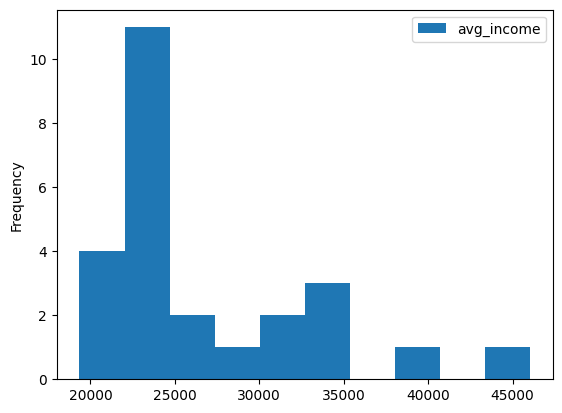

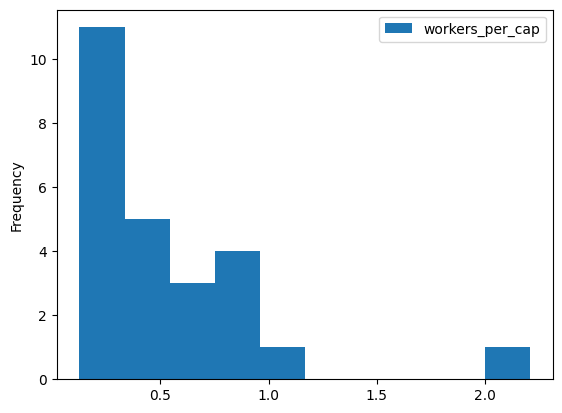

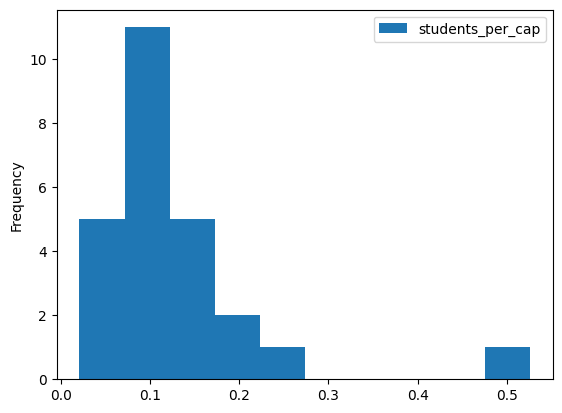

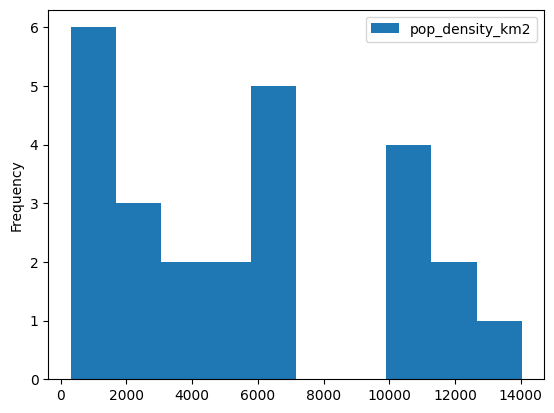

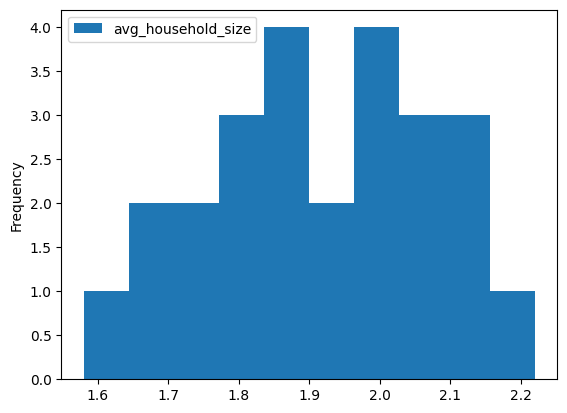

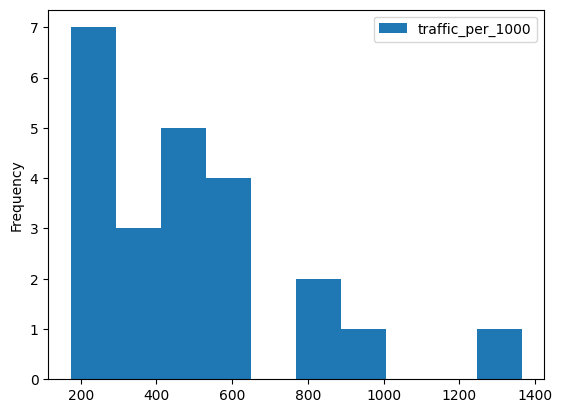

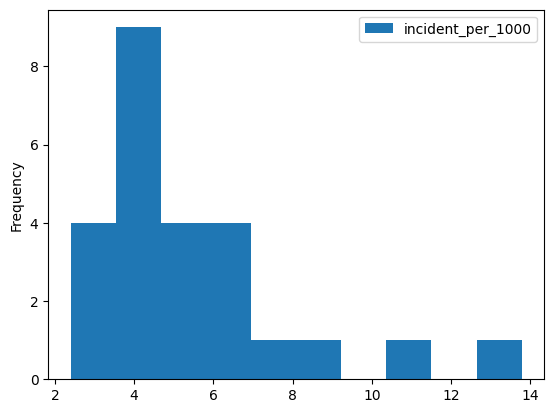

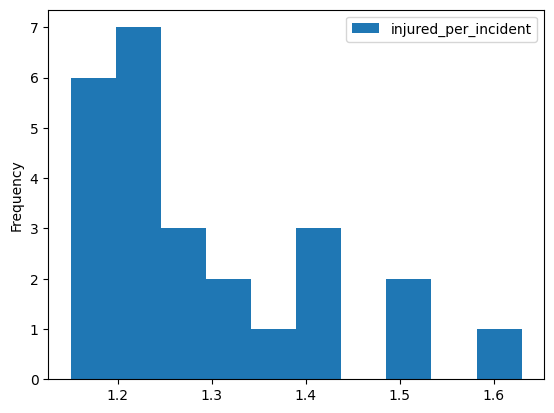

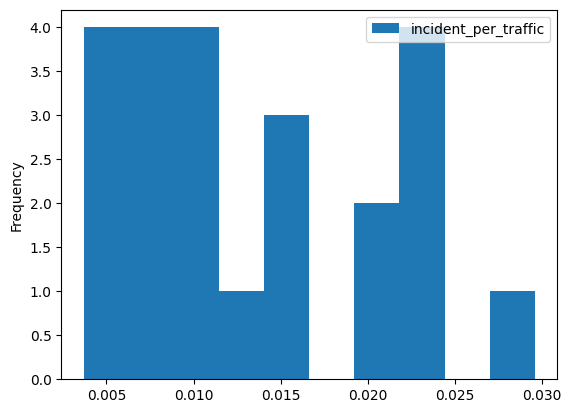

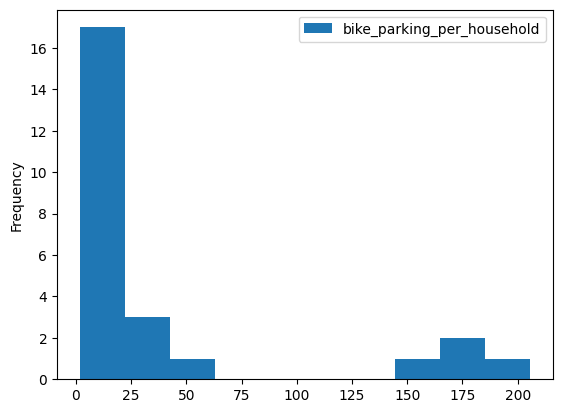

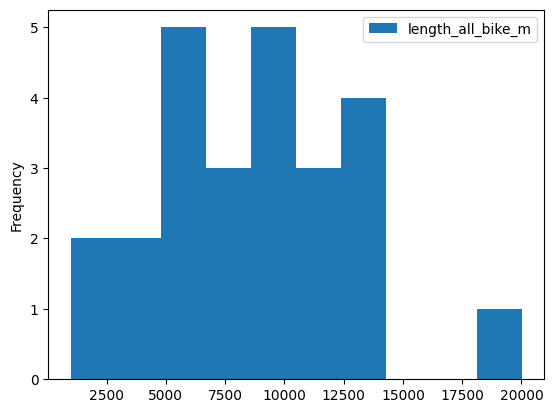

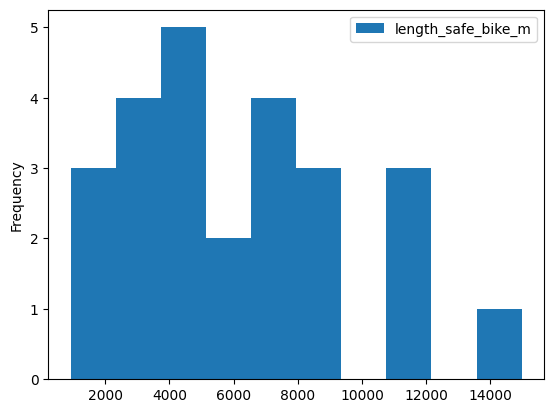

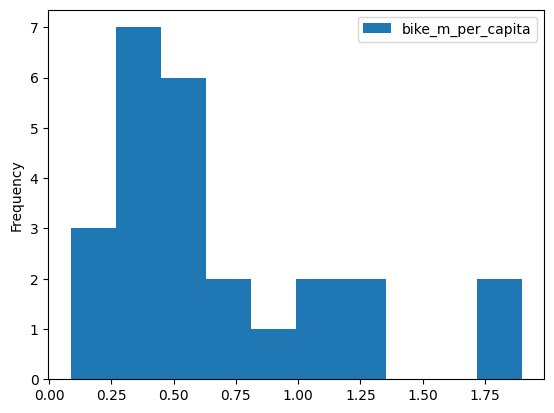

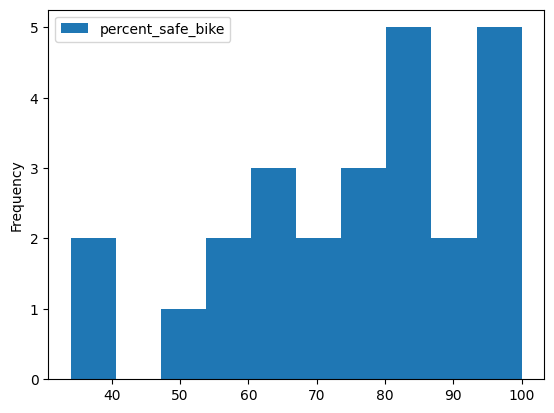

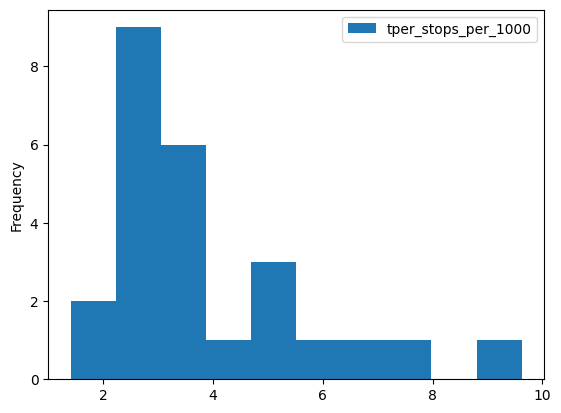

In [5]:
# plot the distribution for each variable to explore variation
for column in df:
    df[[column]].plot.hist()

In [ ]:
# calculate the number of traffic coils per zone to determine the adequacy of this measurement 
base_map_2019.join(traffic_2019_geo.sjoin(base_map_2019[['geometry']]).groupby('index_right')['day_total_traffic'].count()).explore(column = 'day_total_traffic', tooltip= ('day_total_traffic'), cmap = 'RdBu_r')

In [39]:
    # calculate the z-score to give a more standard frame of rereference across metrics
df_z = (df - df.mean())/df.std()
df_z = df_z.fillna(0)

    # create a subset of just base/socioecon related metrics
df_z_socioecon = df_z[['population', '00-14', '15-29', '30-44', '45-64',
       '65 e oltre', 'avg_income',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size']]

    # create a subset of just transport related metrics
df_z_transport = df_z[['traffic_per_1000', 'injured_per_incident', 'incident_per_traffic', 'bike_parking_per_household', 'bike_m_per_capita', 'percent_safe_bike','tper_stops_per_1000']]

In [9]:
df

,population,00-14,15-29,30-44,45-64,65 e oltre,avg_income,workers_per_cap,students_per_cap,pop_density_km2,...,traffic_per_1000,incident_per_1000,injured_per_incident,incident_per_traffic,bike_parking_per_household,length_all_bike_m,length_safe_bike_m,bike_m_per_capita,percent_safe_bike,tper_stops_per_1000
zona_fiu,,,,,,,,,,,,,,,,,,,,,
BARCA,21097.0,12.0,13.0,17.0,29.0,29.0,22480.0,0.2396,0.1498,6351.0,...,346.6498,3.7920,1.2375,0.0109,3.8175,13632.470820,11239.920949,0.6462,82.0,2.6070
BERTALIA - NOCE,7489.0,12.0,14.0,19.0,30.0,24.0,22145.0,0.2867,0.1650,810.0,...,NaN,3.6053,1.6296,NaN,3.3679,8960.368856,8646.757303,1.1965,97.0,5.2076
BEVERARA,7138.0,12.0,13.0,18.0,30.0,28.0,22203.0,0.8124,0.1517,3392.0,...,1364.4214,6.0241,1.4186,0.0044,7.6524,7198.923242,6028.445693,1.0085,84.0,4.9033
BIRRA - BARGELLINO - LAVINO,3922.0,14.0,14.0,22.0,30.0,20.0,22148.0,1.1420,0.0563,302.0,...,NaN,10.7088,1.1667,NaN,2.0736,7106.423358,4324.492227,1.8119,61.0,6.3743
BOLOGNINA,34153.0,13.0,15.0,25.0,28.0,20.0,21139.0,0.3019,0.2082,9974.0,...,173.3826,3.9821,1.1691,0.0230,45.8851,13799.337313,11869.563084,0.4040,86.0,2.2546
BORGO PANIGALE,12424.0,13.0,14.0,20.0,27.0,27.0,21709.0,0.4718,0.1099,1129.0,...,463.3231,7.4855,1.4194,0.0162,12.2918,9699.929225,7586.441705,0.7807,78.0,2.7366
CASTELDEBOLE - PONTELUNGO,10418.0,13.0,12.0,20.0,28.0,27.0,22353.0,0.3936,0.0646,4773.0,...,586.2867,2.3997,1.4000,0.0041,5.3960,10618.868711,7620.125369,1.0193,72.0,2.9756
CIRENAICA - MASSARENTI - SCANDELLARA,29568.0,11.0,15.0,22.0,28.0,23.0,25319.0,0.2771,0.1404,6614.0,...,222.5476,6.5950,1.2718,0.0296,28.6751,13685.524948,11825.469092,0.4628,86.0,3.1791
CORTICELLA - DOZZA,20745.0,12.0,13.0,19.0,30.0,26.0,22998.0,0.5236,0.1155,1869.0,...,273.5170,5.3025,1.3364,0.0194,10.3834,20008.102700,14971.489428,0.9645,75.0,3.9046


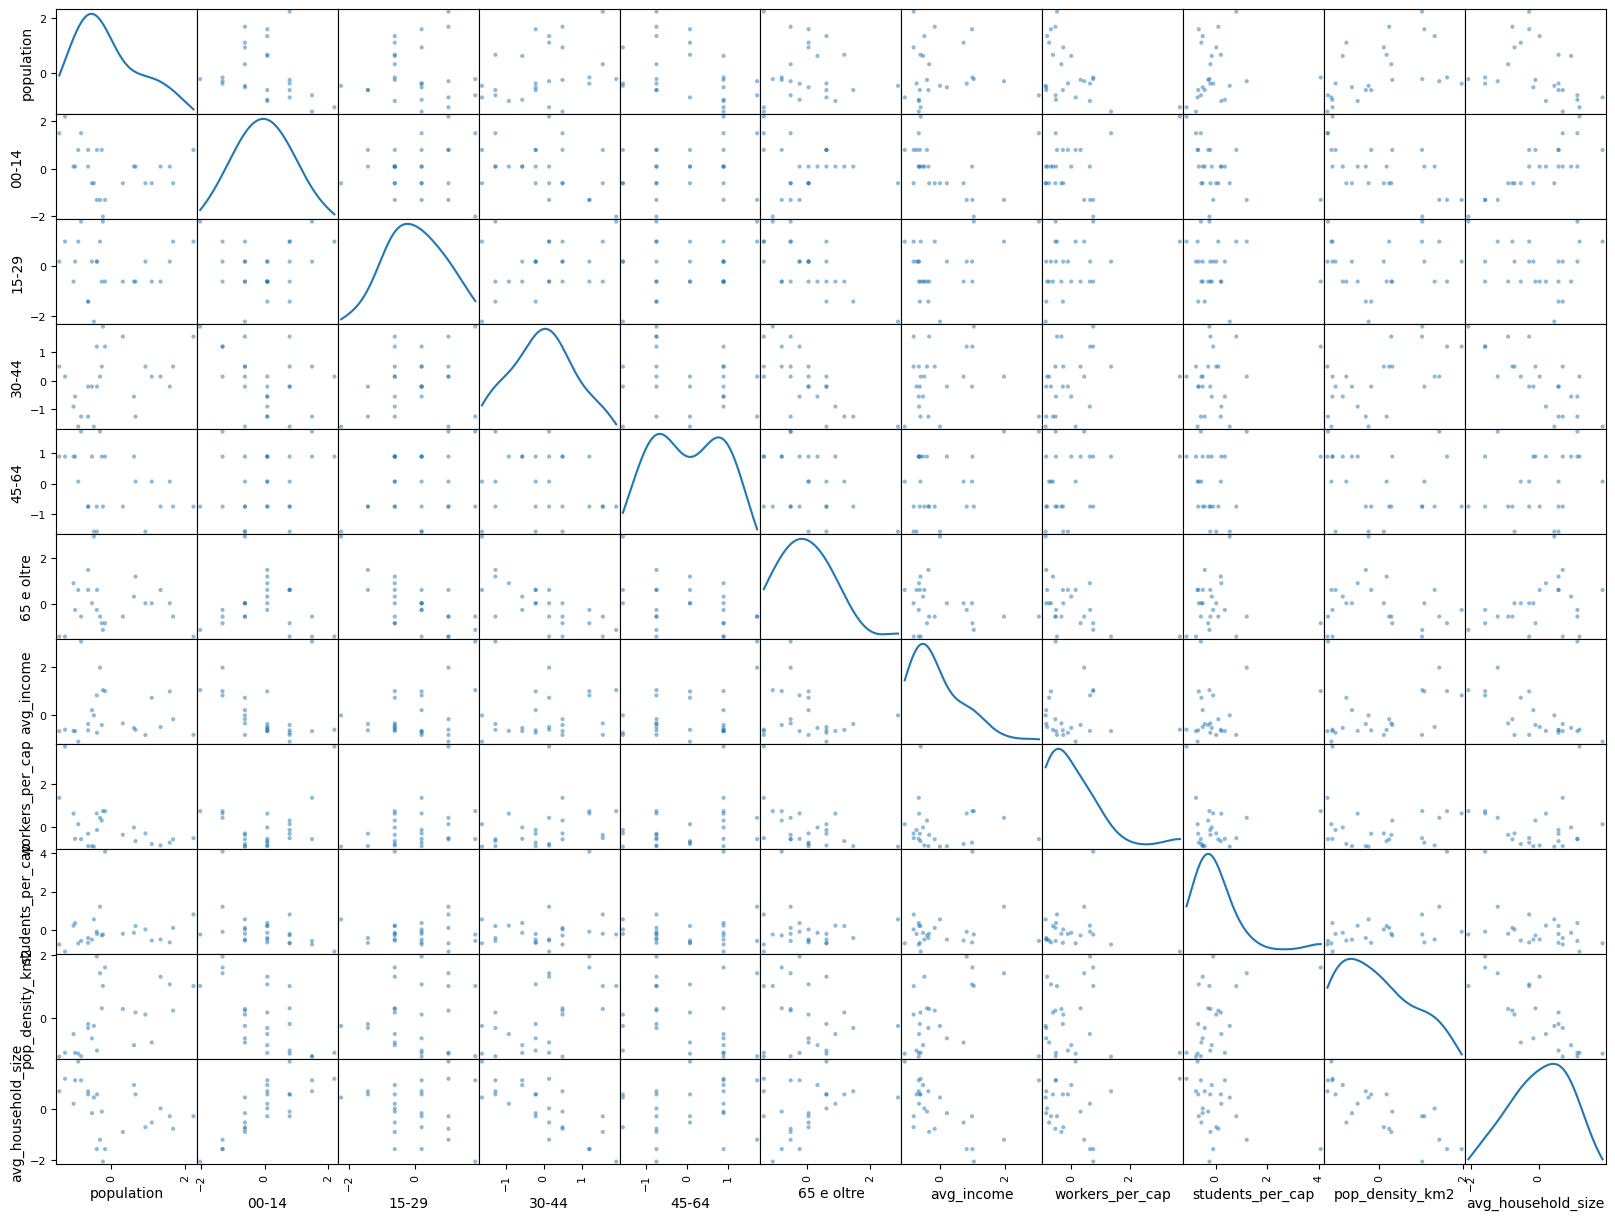

In [24]:
# scattter matrix to view distributions and correlations together
pd.plotting.scatter_matrix(df_z_socioecon, diagonal="kde",figsize=(20,15))
plt.show()
#df_z
#hinton(df_z.corr())
#df_z.corr()

Text(0, 0.5, 'SSE')

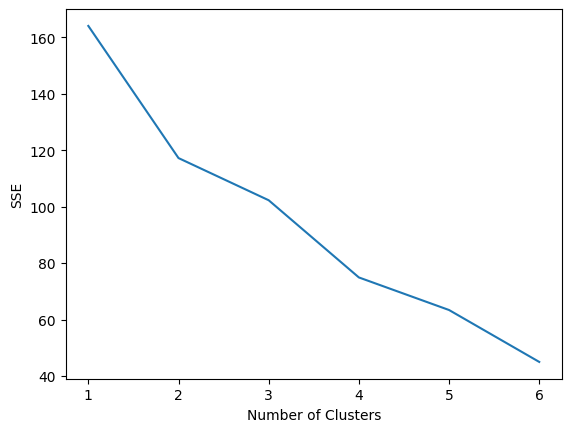

In [45]:
# test for best number of clusters
    # should use n-1 where n is the "elbow" of the plot where slope significantly changes
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_z_transport)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [41]:
# create a cluster class instance using the df_z dataframe, and categorizing into 3 clusters, and having a geo-dataframe that has each zone polygon with its cluster
df_z_clusters_3 = km_cluster_analysis(df_z, 3, base_map_2019)

In [42]:
# display the map of the zones showing the clusters by color and limiting the tooltip to avoid noisy visualization
df_z_clusters_3.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

In [ ]:
# display the average z-score for each metric across each cluster
# this tells about the character of each cluster
# for interpretation: a more negative/positive number means a cluster is characterized by being more below/above the average across all zones
df_z_clusters_3.centroids

In [43]:
# repeat the above analysis but use 4 zones
df_z_clusters_4 = km_cluster_analysis(df_z, 4, base_map_2019)
df_z_clusters_4.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

In [44]:
# display the centroids for the 4-cluster analysis of all metrics
df_z_clusters_4.centroids

,population,00-14,15-29,30-44,45-64,65 e oltre,avg_income,workers_per_cap,students_per_cap,pop_density_km2,avg_household_size,traffic_per_1000,injured_per_incident,incident_per_traffic,bike_parking_per_household,bike_m_per_capita,percent_safe_bike,tper_stops_per_1000
0,-0.150243,-0.149854,-1.425986,-1.383457,-0.752852,1.857261,-0.335775,-0.798794,0.112597,-0.138283,0.584407,-0.113876,-0.254152,-0.769392,-0.529338,-0.307755,0.959775,-0.314319
1,-0.691344,0.722874,0.120796,-0.402886,0.511820,-0.110250,-0.254728,0.346809,-0.396032,-0.804325,0.741990,0.638575,0.492409,-0.414408,-0.514852,0.626911,0.111306,0.580597
2,1.308796,-0.216753,0.078707,0.592910,-0.635949,-0.240262,-0.141386,-0.571126,-0.134809,0.462358,-0.494553,-0.886334,-0.174295,1.081318,-0.217820,-0.509650,-0.099105,-0.548905
3,-0.276516,-1.496196,0.599562,1.107938,0.270045,-0.669300,1.199759,0.644842,1.240556,1.506479,-1.613310,-0.119590,-0.858494,-0.175641,2.194032,-0.601303,-0.852489,-0.400318


In [19]:
# perform 4-cluster analysis on df_z_socioecon (socioecon metrics only) and display results
df_socio_clusters_3 = km_cluster_analysis(df_z_socioecon, 3, base_map_2019)
df_socio_clusters_3.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

# interesting result: zone Beverara is the only zone that has changed. indicates that this zone is more similar to zone 2 socioeconomically speaking but more similar to 0 when considering the transportation metrics

In [17]:
# perform 4-cluster analysis on df_z_socioecon (socioecon metrics only) and display results
df_socio_clusters_4 = km_cluster_analysis(df_z_socioecon, 4, base_map_2019)
df_socio_clusters_4.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))

# interesting result: zone Beverara is the only zone that has changed. indicates that this zone is more similar to zone 2 socioeconomically speaking but more similar to 0 when considering the transportation metrics

In [20]:
# display the centroids for the 4-cluster analysis of just socioeconomic metrics
df_socio_clusters_4.centroids

,population,00-14,15-29,30-44,45-64,65 e oltre,avg_income,workers_per_cap,students_per_cap,pop_density_km2,avg_household_size
0,-0.270638,0.084293,-1.425986,-1.090351,-0.752852,1.547399,-0.411407,-0.673109,-0.082989,-0.153066,0.584407
1,-0.697296,0.716488,0.275475,-0.422071,0.638287,-0.183056,-0.216371,0.411095,-0.368661,-0.865015,0.757748
2,1.308796,-0.216753,0.078707,0.592910,-0.635949,-0.240262,-0.141386,-0.571126,-0.134809,0.462358,-0.494553
3,-0.276516,-1.496196,0.599562,1.107938,0.270045,-0.669300,1.199759,0.644842,1.240556,1.506479,-1.613310


In [46]:
# perform cluster analysis on df_z_transport (transport metrics only) and display results
# screeplot (the "elbow" graph) analysis of this dataset yielded a result that suggested 2 clusters was most meaningful 
df_transport_clusters_3 = km_cluster_analysis(df_z_transport, 3, base_map_2019)
df_transport_clusters_3.geo.explore(column = 'Cluster ID', tooltip = ('zona_fiu','Cluster ID'))
# should try to add more transportation related metrics and determine if this creates more meaningful insight

In [47]:
# display the centroids for the 4-cluster analysis of just socioeconomic metrics
df_transport_clusters_3.centroids

,traffic_per_1000,injured_per_incident,incident_per_traffic,bike_parking_per_household,bike_m_per_capita,percent_safe_bike,tper_stops_per_1000
0,0.749433,0.539975,-0.942646,-0.532480,-0.150611,0.880488,0.262826
1,-0.574915,-0.267610,0.552224,0.417048,-0.369350,-0.250558,-0.469751
2,0.684450,-0.191086,-0.063320,-0.526275,2.125261,-1.178696,1.491303


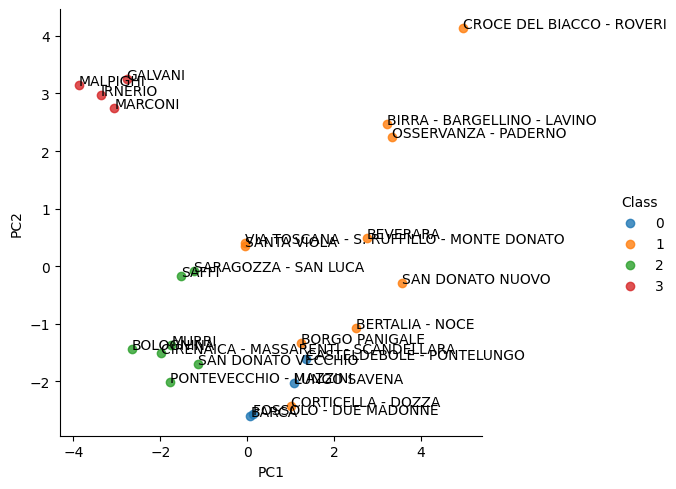

In [28]:
    # principal compoenents analysis
# set the resulting categories of the cluster analysis as dependent variable 
y = df_socio_clusters_4.geo.reset_index()[['zona_fiu','Cluster ID']]

# define the principal component analysis from the standardized z-score data
pca = PCA().fit(df_z)

# output the summary statistics for each principal component
#pca_summary(pca, df_z)

# display the coefficients for the first principal component
#pca.components_[0]

# display the screeplot to determine the number of principal components to retain
# should use n-1 where n is where the "elbow" of the plot occurs - where the slope significantly changes
#screeplot(pca, df_z) 
    # based on result - retain the first 3 principal components

# display a scatterplot of the data to show the clusters in comparison to the first two principal components
pca_scatter(pca, df_z, y)
# the PCA analysis and the cluster analysis appear compatible

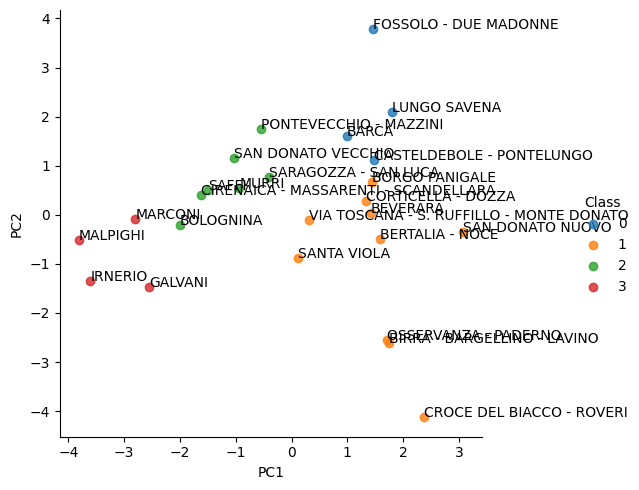

In [29]:
# repeat the analysis with the socioeconomic metrics
y_socioecon = df_socio_clusters_4.geo.reset_index()[['zona_fiu','Cluster ID']]
pca_socioecon = PCA().fit(df_z_socioecon)
pca_scatter(pca_socioecon, df_z_socioecon, y_socioecon)

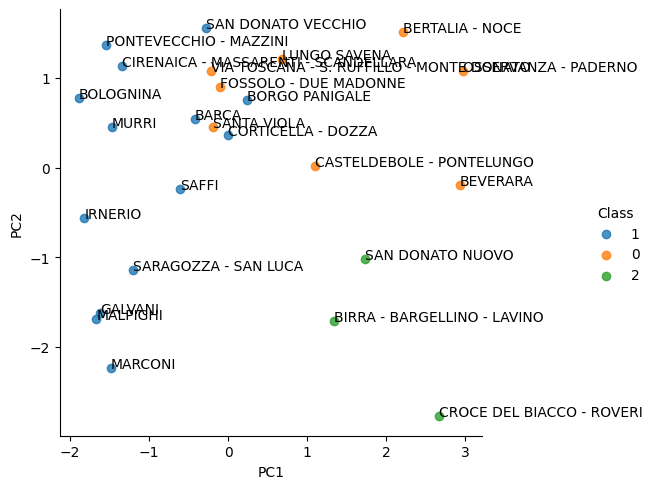

In [48]:
# repeat the analysis with the transport metrics
y_transport = df_transport_clusters_3.geo.reset_index()[['zona_fiu','Cluster ID']]
pca_transport = PCA().fit(df_z_transport)
pca_scatter(pca_transport, df_z_transport, y_transport)
# conclusion as of 19/7 - the analysis of the combined dataset is still being driven heavily by the summary statistics 
# removing the summary stats leads to a weak grouping from the transport related metrics into two clusters - interior and exterior
# continue adding metrics

In [ ]:
# hierarchical clustering - provides ability to see further granularity and inter-group similarities / differences compared to k-means

# average linkage - compares using average distance between members of each cluster
linkage_matrix = linkage(df_z, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [ ]:
# repeat the hierarchical clustering from above but only with the transport related metrics
linkage_matrix = linkage(df_z_transport, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z_transport.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()